In [23]:
#importing all the necessary libraries

import numpy as np
from pathlib import Path
import random
import torch
import torchvision
import tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Loading the dataset

The following blocks of code, load the dataset and perform transformations on it. The following cell provides a brief explanation of each transform used in the code:

1. `RandomResizedCrop:` This transform randomly crops a portion of the image and resizes it to the desired size. It is commonly used for data augmentation to increase the variability of the images in the dataset. In the code, I used a crop size of 224, which is a common size used in many deep learning models.

2. `RandomHorizontalFlip:` This transform randomly flips the image horizontally with a probability of 0.5. This is another commonly used data augmentation technique to increase the variability of the dataset.

3. `ColorJitter:` This transform randomly adjusts the brightness, contrast, saturation, and hue of the image. It can be used to create a more robust model that is able to handle variations in lighting conditions, color distributions, and other factors that may affect the appearance of the images in the dataset.

4. `ToTensor:` This transform converts the image into a PyTorch tensor. PyTorch tensors are the primary data structure used in PyTorch for deep learning computations.

5. `Normalize:` This transform normalizes the tensor by subtracting the mean and dividing by the standard deviation. Normalization helps to bring the data into a common scale and can improve the convergence of the training process.



In [31]:
# Define the path to the directory containing the images
data_dir = "../dataset"

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop the images and resize them to (224, 224)
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),   # Randomly flip the images horizontally
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),   # Apply color jittering
    transforms.ToTensor(),   # Convert the images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])   # Normalize the images
])

# Create a dataset object from the ImageFolder class
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Get the class names from the dataset object
class_names = dataset.classes

# Print the class names
print("Class names:", class_names)


Class names: ['no', 'yes']


In [32]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for the train and test sets
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
# Define the CNN model
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [34]:
import torch.optim as optim
model = Net()

# Define the binary cross-entropy loss and the stochastic gradient descent optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model for 10 epochs
for epoch in range(10):
    running_loss = 0.0
    correct_predictions = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        correct_predictions += (predictions == labels.float().unsqueeze(1)).sum().item()

        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 100, correct_predictions / (100 * BATCH_SIZE)))
            running_loss = 0.0
            correct_predictions = 0

    # Evaluate the model on the validation set
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predictions == labels.float().unsqueeze(1)).sum().item()

    print('Epoch: %d, Loss: %.3f, Train Accuracy: %.3f, Validation Accuracy: %.3f' % (epoch + 1, running_loss / len(train_loader), correct_predictions / (len(train_loader) * batch_size), correct / total))

print('Finished training')


Epoch: 1, Loss: 0.686, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 2, Loss: 0.674, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 3, Loss: 0.670, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 4, Loss: 0.652, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 5, Loss: 0.660, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 6, Loss: 0.636, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 7, Loss: 0.633, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 8, Loss: 0.624, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 9, Loss: 0.629, Train Accuracy: 0.580, Validation Accuracy: 0.490
Epoch: 10, Loss: 0.617, Train Accuracy: 0.580, Validation Accuracy: 0.490
Finished training


Test Loss: 0.6810, Test Accuracy: 13.6471


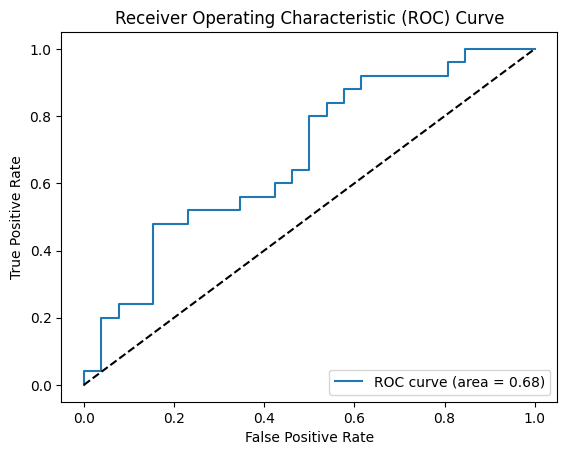

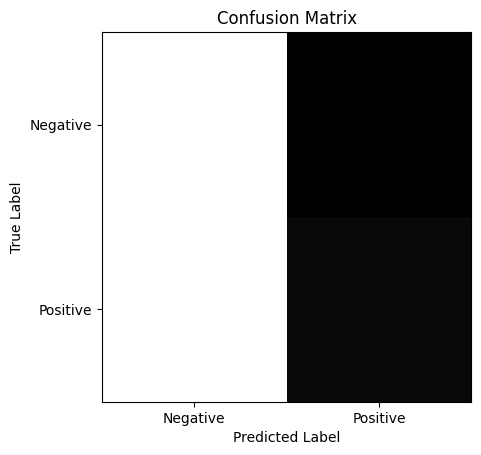

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy function
def accuracy(predictions, labels):
    predicted_classes = torch.round(torch.sigmoid(predictions))
    correct = (predicted_classes == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Set the model to evaluation mode
model.eval()

# Initialize the accuracy and loss variables
test_loss = 0
test_acc = 0
total = 0

# Initialize the lists for storing the predicted and true labels
all_preds = []
all_labels = []

# Loop through the test dataset
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        
        # Update the accuracy and loss variables
        test_loss += loss.item() * inputs.size(0)
        test_acc += accuracy(outputs, labels) * inputs.size(0)
        total += inputs.size(0)
        
        # Store the predicted and true labels
        all_preds.extend(torch.sigmoid(outputs).squeeze().tolist())
        all_labels.extend(labels.tolist())

# Calculate the final accuracy and loss
test_loss = test_loss / total
test_acc = test_acc / total

# Print the accuracy and loss
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

# Plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

preds = torch.round(torch.sigmoid(torch.tensor(all_preds)))
conf_matrix = confusion_matrix(all_labels, preds)
plt.imshow(conf_matrix, cmap='binary', interpolation='None')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
